## **IMPORT COMMON PACKAGES DAN DATASET**

In [2]:
import pandas as pd
import missingno as msno

In [3]:
data = pd.read_csv('mobile.csv')

pd.options.display.max_columns = 100
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


## **CEK MISSING VALUES**

<Axes: >

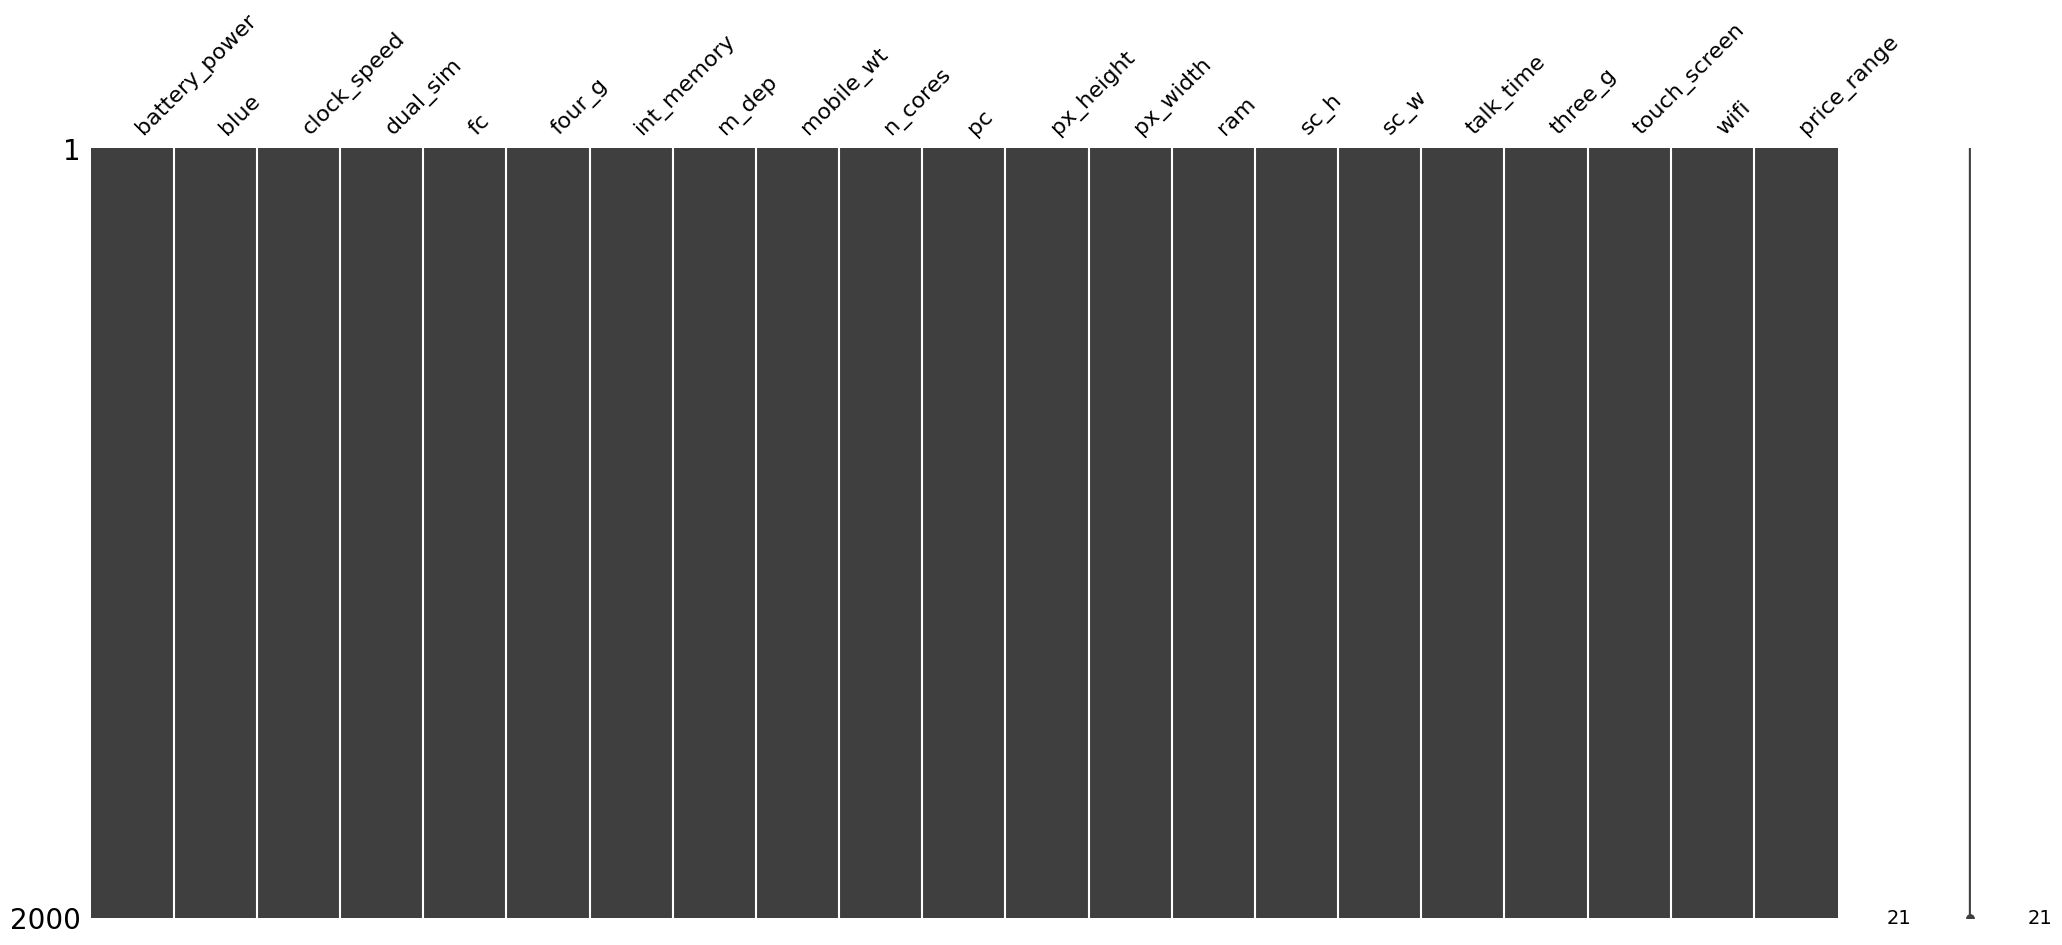

In [4]:
msno.matrix(data)

## **Feature Selection**

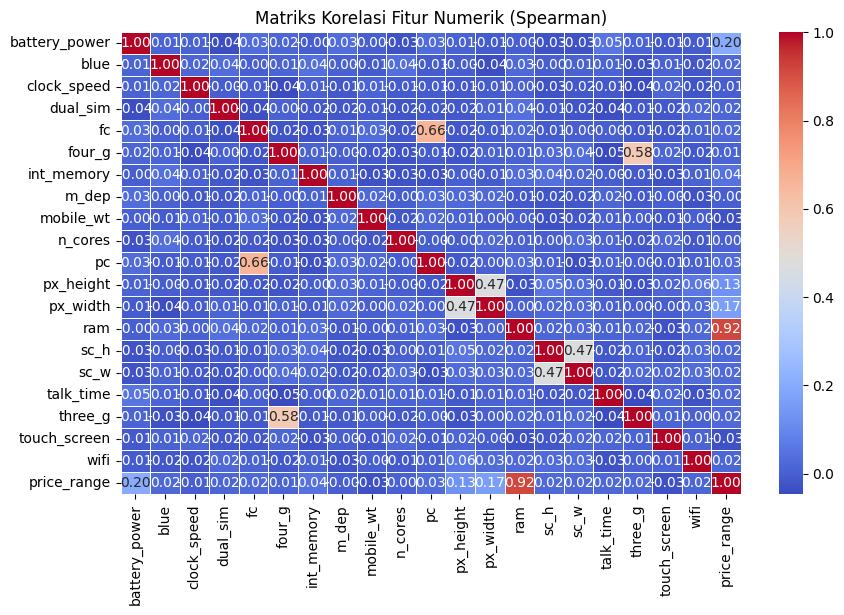

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_method = "spearman"

plt.figure(figsize=(10, 6))
sns.heatmap(data.select_dtypes(include=["number"]).corr(method=correlation_method),
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Matriks Korelasi Fitur Numerik ({correlation_method.capitalize()})")
plt.show()

In [6]:
df = data[['price_range', 'ram', 'px_width', 'px_height', 'battery_power']]
df.head()

,price_range,ram,px_width,px_height,battery_power
0,1,2549,756,20,842
1,2,2631,1988,905,1021
2,2,2603,1716,1263,563
3,2,2769,1786,1216,615
4,1,1411,1212,1208,1821


## **DATA SPLITTING**

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="price_range")
y = df["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 4), (400, 4), (1600,), (400,))

## **TRAINING MODEL**

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
X_train.head()

,ram,px_width,px_height,battery_power
469,1731,695,292,1845
565,445,1949,1350,1271
396,3969,1161,42,788
452,3915,1366,1017,1406
325,785,1078,209,920


In [10]:
from sklearn.preprocessing import PolynomialFeatures

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), ['battery_power', 'px_height', 'px_width', 'ram']),
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', RandomForestClassifier(random_state=42))
])

parameter = {
    'algo__n_estimators': [50, 100, 200],
    'algo__max_depth': [10, 20, None],
    'algo__max_features': ['sqrt', 'log2', None],
    'algo__min_samples_leaf': [1, 2, 4]
}

In [11]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomizedSearchCV(pipeline, param_distributions=parameter, n_iter=50, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(include_bias=False))]),
                                                                               ['battery_power',
                                                                                'px_height',
                                                                                'px_width',
                                                                                'ram'])])),
                                             ('algo',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__max_depth': [10, 20, None],
                                        'algo__max_features': ['sqrt', 'log2',
                                                               None],
                                        'algo__min_samples_leaf': [1, 2, 4],
                                        'algo__n_estimators': [50, 100, 200]},
                   verbose=1)

In [12]:
print(f"Best parameters: {model.best_params_}")
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Best parameters: {'algo__n_estimators': 200, 'algo__min_samples_leaf': 1, 'algo__max_features': 'log2', 'algo__max_depth': None}
1.0 0.9268761140506824 0.9525


## **Evaluasi Model**

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}\n")

print("**Evaluasi pada Data Test**")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

Jumlah data train: 1600
Jumlah data test: 400

**Evaluasi pada Data Train**
Akurasi: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

**Evaluasi pada Data Test**
Akurasi: 0.9525
Precision: 0.9522
Recall: 0.9525
F1-Score: 0.9523


In [14]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Classification Report - Train Data:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       0.94      0.93      0.93       100
           2       0.93      0.91      0.92       100
           3       0.97      0.97      0.97       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



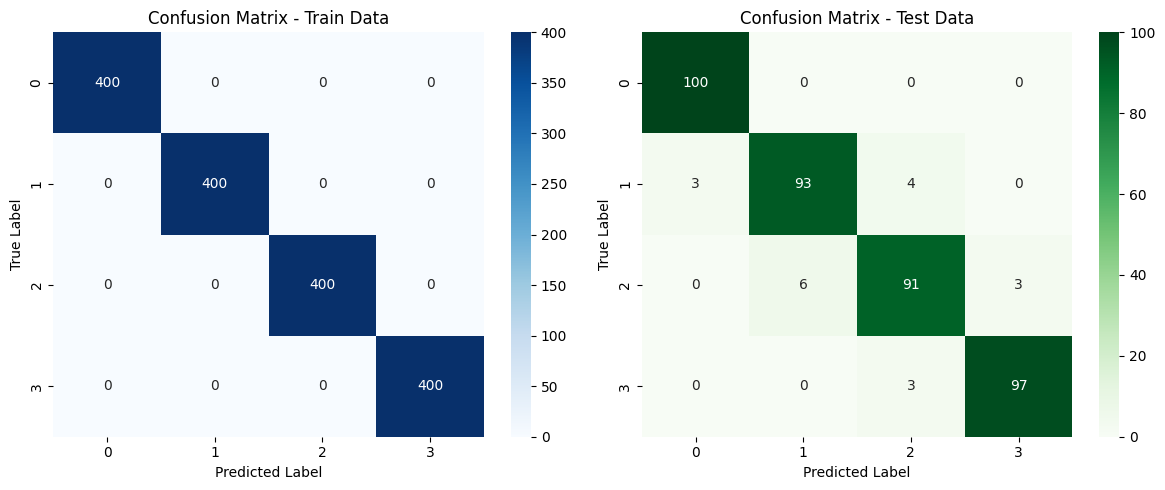

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [17]:
y_train.value_counts()

,count
price_range,
1,400
0,400
3,400
2,400


<ipython-input-16-cc512cdb384f>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


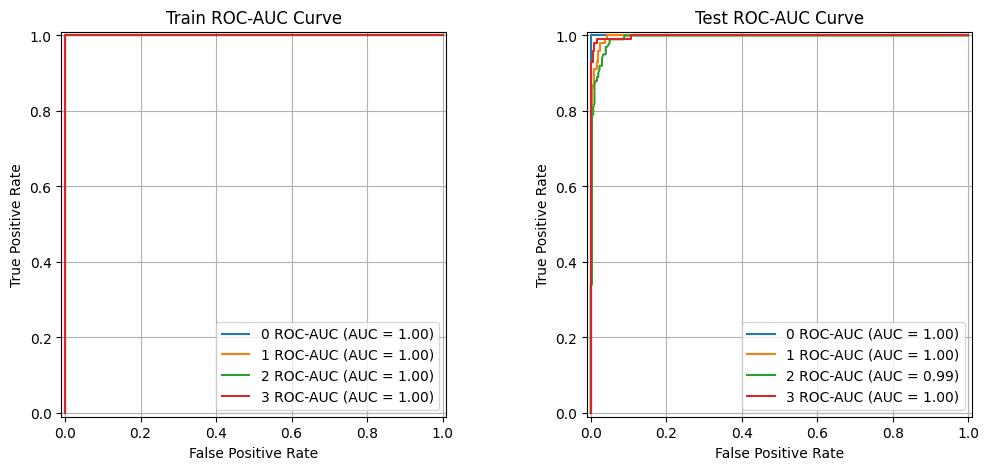

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

class_names = lb.classes_

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

for i in range(y_train_binarized.shape[1]):
    y_train_score = model.predict_proba(X_train)[:, i]
    fpr_train, tpr_train, _ = roc_curve(y_train_binarized[:, i], y_train_score)
    roc_auc_train = auc(fpr_train, tpr_train)
    RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train).plot(
        ax=ax[0], name=f"{class_names[i]} ROC-AUC"
    )

ax[0].set_title("Train ROC-AUC Curve")
ax[0].grid(True)

for i in range(y_test_binarized.shape[1]):
    y_test_score = model.predict_proba(X_test)[:, i]
    fpr_test, tpr_test, _ = roc_curve(y_test_binarized[:, i], y_test_score)
    roc_auc_test = auc(fpr_test, tpr_test)
    RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test).plot(
        ax=ax[1], name=f"{class_names[i]} ROC-AUC"
    )

ax[1].set_title("Test ROC-AUC Curve")
ax[1].grid(True)

plt.tight_layout()
plt.show()

<ipython-input-18-a5a20379db2a>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


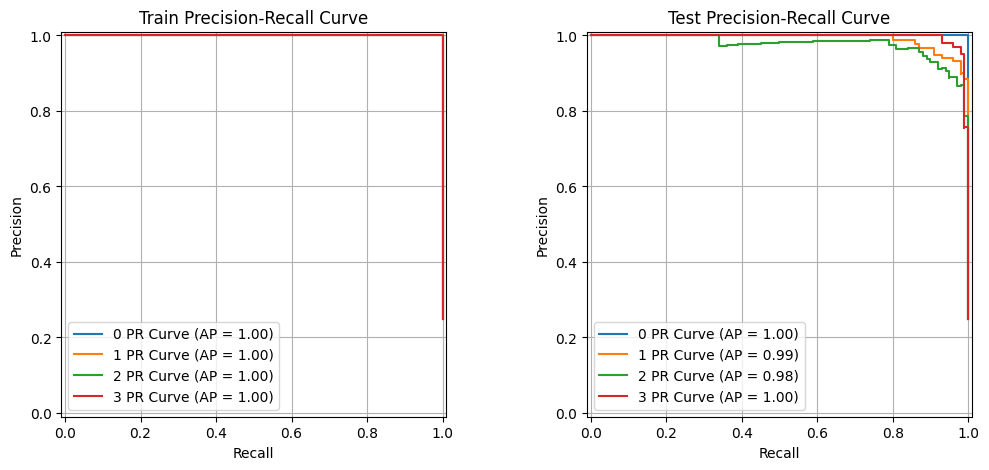

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

class_names = lb.classes_

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

for i in range(y_train_binarized.shape[1]):
    y_train_score = model.predict_proba(X_train)[:, i]
    precision_train, recall_train, _ = precision_recall_curve(y_train_binarized[:, i], y_train_score)
    avg_precision_train = average_precision_score(y_train_binarized[:, i], y_train_score)
    PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=avg_precision_train).plot(
        ax=ax[0], name=f"{class_names[i]} PR Curve"
    )

ax[0].set_title("Train Precision-Recall Curve")
ax[0].grid(True)

for i in range(y_test_binarized.shape[1]):
    y_test_score = model.predict_proba(X_test)[:, i]
    precision_test, recall_test, _ = precision_recall_curve(y_test_binarized[:, i], y_test_score)
    avg_precision_test = average_precision_score(y_test_binarized[:, i], y_test_score)
    PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=avg_precision_test).plot(
        ax=ax[1], name=f"{class_names[i]} PR Curve"
    )

ax[1].set_title("Test Precision-Recall Curve")
ax[1].grid(True)

plt.tight_layout()
plt.show()

## **Feature Importance**

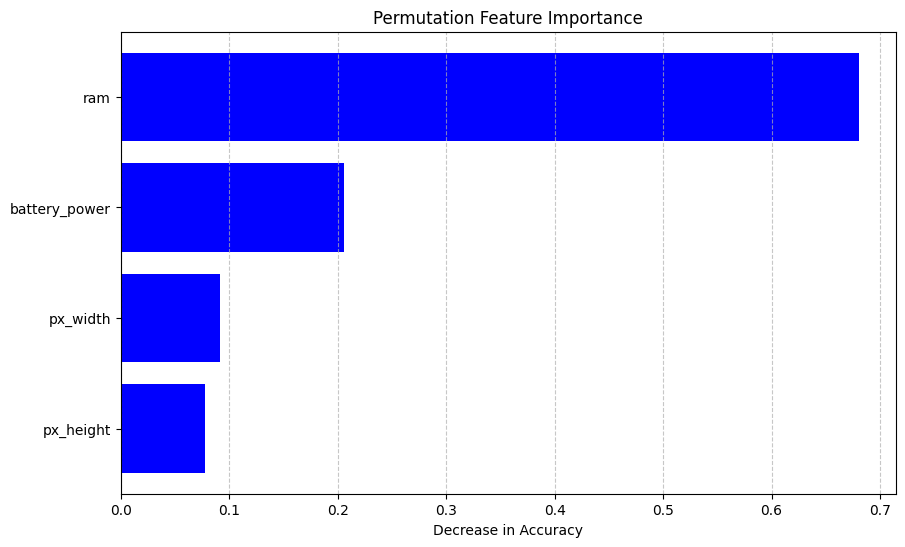

In [19]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='blue')
plt.title('Permutation Feature Importance')
plt.xlabel('Decrease in Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## **PREDIKSI**

In [20]:
X_train.iloc[1]

,565
ram,445
px_width,1949
px_height,1350
battery_power,1271


In [21]:
new_data = pd.DataFrame({
    'ram': [1024, 2048, 4096, 6144, 8192],
    'px_width': [1080, 1440, 1920, 2560, 1280],
    'px_height': [1920, 2560, 1080, 3840, 720],
    'battery_power': [2000, 3000, 4000, 5000, 6000]
})

new_data['Predict'] = model.predict(new_data)
new_data

,ram,px_width,px_height,battery_power,Predict
0,1024,1080,1920,2000,1
1,2048,1440,2560,3000,2
2,4096,1920,1080,4000,3
3,6144,2560,3840,5000,3
4,8192,1280,720,6000,3


## **SAVE MODEL**

In [22]:
import pickle

with open('mobile.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model berhasil disimpan")

Model berhasil disimpan
